In [1]:
import os 
import pandas as pd
import numpy as np
import xarray as xr
import geopandas as gpd
from rasterio import features
from affine import Affine
# TP: added so that rotated longitudes can be normalised to the range 0 to 360 (Proj makes them -180 to 180)
from shapely.ops import transform

from matplotlib import style
import matplotlib as mpl
import cartopy.crs as crs
import pyproj
from matplotlib import pyplot as plt
from matplotlib.colors import Normalize
from matplotlib.pyplot import cm 

import math
import sys
#sys.path.append("/Users/sarah/anaconda3/envs/py36/bin")
#from Rotated_Pole import rotated_grid_transform 


In [2]:
class MidpointNormalize(Normalize):
    def __init__(self, vmin=None, vmax=None, midpoint=None, clip=False):
        self.midpoint = midpoint
        Normalize.__init__(self, vmin, vmax, clip)

    def __call__(self, value, clip=None):
        # I'm ignoring masked values and all kinds of edge cases to make a
        # simple example...
        x, y = [self.vmin, self.midpoint, self.vmax], [0, 0.5, 1]
        return np.ma.masked_array(np.interp(value, x, y))

normalized = MidpointNormalize(midpoint=0)

# Code adapted from https://nbviewer.jupyter.org/github/scott-hosking/notebooks/blob/master/racmo_with_xarray.ipynb

In [3]:
def projection_latlon (ds):
	p = pyproj.Proj('+ellps=WGS84 +proj=ob_tran +o_proj=latlon +o_lat_p=6.08 +o_lon_p=-166.92 +lon_0=180.0')
	rad2deg = 180./np.pi
	rlon = ds.rlon.values
	rlat = ds.rlat.values
	x1,y1 = np.meshgrid(rlon, rlat)
	lon, lat = p(x1, y1) 
	lon, lat = lon*rad2deg, lat*rad2deg    # radians --> degrees
	return x1, y1, lon, lat

# Adapted from https://gist.github.com/shoyer/0eb96fa8ab683ef078eb

In [4]:
def transform_from_latlon(lat, lon):
    lat = np.asarray(lat)
    lon = np.asarray(lon)
    # TP: offset the translation by 1/2 a pixel as I suspect rasterize is treating it as the top-left corner
    #     of the corner pixel, but the RACMO coordinates are the pixel centres
    trans = Affine.translation(lon[0] - (lon[1]-lon[0])/2, lat[0] - (lat[1]-lat[0])/2)
    scale = Affine.scale(lon[1] - lon[0], lat[1] - lat[0])
    return trans * scale

def rasterize(shapes, coords, fill=np.nan, **kwargs):
    """Rasterize a list of (geometry, fill_value) tuples onto the given
    xray coordinates. This only works for 1d latitude and longitude
    arrays.
    """
    transform = transform_from_latlon(coords['lat'], coords['lon'])
    out_shape = (len(coords['lat']), len(coords['lon']))
    raster = features.rasterize(shapes, out_shape=out_shape,
                                fill=fill, transform=transform,
                                dtype=float, **kwargs)
    return xr.DataArray(raster, coords=coords, dims=('lat', 'lon'))

In [5]:
Antarctica_RCP85_SNM_ECEARTH_KNMI = xr.open_dataset ('snm_ANT-44_ICHEC-EC-EARTH_historical_r1i1p1_KNMI-RACMO21P_v1_day_19960101-20001231.nc')


# Preview of unrotated mean snm

C:\Users\toil\AppData\Local\Continuum\anaconda3\lib\site-packages\xarray\core\nanops.py:142: RuntimeWarning: Mean of empty slice
  return np.nanmean(a, axis=axis, dtype=dtype)


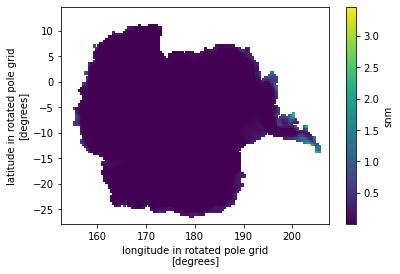

In [6]:
Antarctica_RCP85_SNM_ECEARTH_KNMI.snm.mean('time').plot()

In [7]:
print (Antarctica_RCP85_SNM_ECEARTH_KNMI.snm.units)

kg m-2 s-1


In [23]:
Antarctica_RCP85_SNM_ECEARTH_KNMI

<xarray.Dataset>
Dimensions:       (bnds: 2, rlat: 97, rlon: 125, time: 1827)
Coordinates:
  * rlon          (rlon) float64 152.7 153.2 153.6 154.0 ... 206.4 206.8 207.3
    lon           (rlat, rlon) float64 60.02 59.61 59.2 ... -115.3 -114.9 -114.4
  * rlat          (rlat) float64 -27.72 -27.28 -26.84 ... 13.64 14.08 14.52
    lat           (rlat, rlon) float64 -56.27 -56.58 -56.9 ... -56.34 -56.0
  * time          (time) datetime64[ns] 1996-01-01T12:00:00 ... 2000-12-31T12...
Dimensions without coordinates: bnds
Data variables:
    rotated_pole  |S1 b''
    time_bnds     (time, bnds) datetime64[ns] 1996-01-01 ... 2001-01-01
    snm           (time, rlat, rlon) float32 nan nan nan nan ... nan nan nan nan
Attributes:
    Conventions:                    CF-1.4
    contact:                        Erik van Meijgaard, KNMI, Regional Climat...
    experiment:                     Historical run
    experiment_id:                  historical
    realization:                    1
    driving_experiment:             ICHEC-EC-EARTH,historical,r1i1p1
    driving_model_id:               ICHEC-EC-EARTH
    driving_model_ensemble_member:  r1i1p1
    driving_experiment_name:        historical
    institution:                    Royal Netherlands Meteorological Institut...
    institute_id:                   KNMI
    model_id:                       KNMI-RACMO21P
    rcm_version_id:                 v1
    references:                     http://www.knmi.nl/research/regional_clim...
    project_id:                     CORDEX
    CORDEX_domain:                  ANT-44
    product:                        output
    frequency:                      day
    knmi_global_comment:            
    knmi_model_comment:             RACMO21P: baseline physics from ECMWF CY2...
    knmi_version_comment:           v1: reference version for polar regions
    knmi_grib_path:                 mos.knmi.nl:/climreg/CXANT50/xR2v1-v413-f...
    creation_date:                  2013-12-29T18:33:54Z
    tracking_id:                    feb947e3-eb76-4219-a239-db7ea92e7e04

# Plot with regridded (2D) coordinates

C:\Users\toil\AppData\Local\Continuum\anaconda3\lib\site-packages\xarray\core\nanops.py:142: RuntimeWarning: Mean of empty slice
  return np.nanmean(a, axis=axis, dtype=dtype)


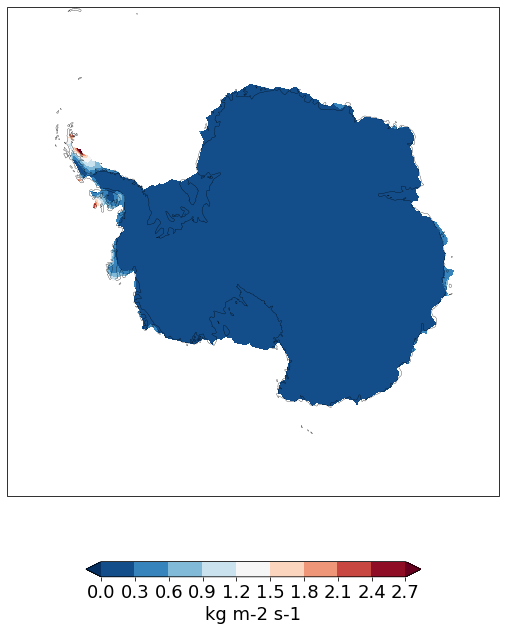

In [8]:
x,y,Lon, Lat = projection_latlon(Antarctica_RCP85_SNM_ECEARTH_KNMI)

projection=crs.SouthPolarStereo()
plot_coords = projection.transform_points(crs.PlateCarree(), Lon, Lat)
x1, y1 = plot_coords[:,:,0], plot_coords[:,:,1]
plt.figure(figsize=(12,12))
ax = plt.subplot( projection=projection )
ax.set_extent([-180,180,-90,-60], crs.PlateCarree())
levels = np.arange (0, 3, .3) 
cmap=mpl.cm.RdBu_r
cmap.set_bad('white',1.)
fill=ax.contourf(x1, y1, Antarctica_RCP85_SNM_ECEARTH_KNMI.snm.mean('time'), extend='both', cmap=cmap,
                    levels=levels, transform=projection)#norm=normalized,
ax.coastlines( linewidth=0.3)
#ax.add_feature(cartopy.feature.OCEAN, facecolor="white",zorder=3) 
cb= plt.colorbar(fill,orientation='horizontal', shrink=.5,aspect=20, pad=0.1)#,
cb.ax.tick_params(labelsize=18) 
cb.set_label(Antarctica_RCP85_SNM_ECEARTH_KNMI.snm.units, fontsize=18)

# Your first approach (based on the original rotated rlat/rlon coordinates) isn't working for me. I have not figured out why yet 

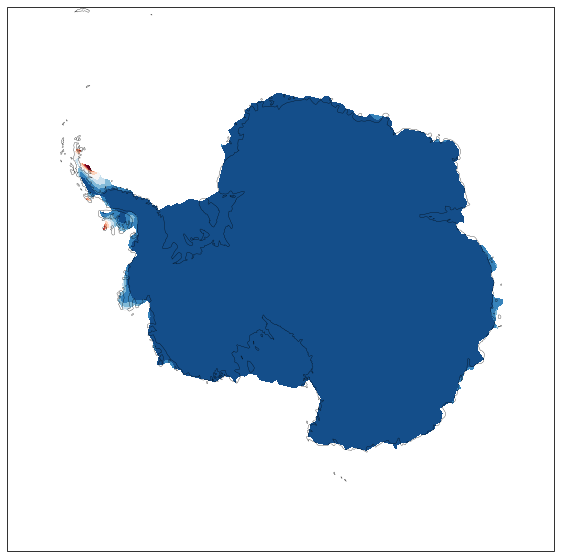

In [9]:
rotated_pole = crs.RotatedPole(pole_latitude=Antarctica_RCP85_SNM_ECEARTH_KNMI.rotated_pole.grid_north_pole_latitude,
                               pole_longitude=Antarctica_RCP85_SNM_ECEARTH_KNMI.rotated_pole.grid_north_pole_longitude,)
#print(rotated_pole.proj4_params)

plt.figure(figsize=(10,10))
ax = plt.subplot( projection=projection)
ax.set_extent([-180,180,-90,-60], crs.PlateCarree())
fill_rotated = ax.contourf(Antarctica_RCP85_SNM_ECEARTH_KNMI.rlon.values, Antarctica_RCP85_SNM_ECEARTH_KNMI.rlat.values, Antarctica_RCP85_SNM_ECEARTH_KNMI.snm.mean('time'), levels,extend='both', cmap=cmap, transform=rotated_pole)
ax.coastlines(linewidth=0.3)
# TP: remove color bar so that the plot below is directly comparable to the one of the mask at the end (to check alignment)
#plt.colorbar(fill_rotated, orientation='horizontal', label='kg m-2 d-1', extend='both', fraction=0.046, pad=0.04)
#cb.ax.tick_params(labelsize=18) 
#cb.set_label(Antarctica_RCP85_SNM_ECEARTH_KNMI.snm.units, fontsize=18)

# Import shapefiles

Shapefiles from https://nsidc.org/data/nsidc-0709

In [10]:
NSIDC_path= 'IceBoundaries_Antarctica_v02/IceBoundaries_Antarctica_v02.shp'

In [11]:
# projection see netdcdf file
my_proj = pyproj.Proj('+ellps=WGS84 +proj=ob_tran +o_proj=latlon +o_lat_p=6.08 +o_lon_p=-166.92 +lon_0=180.0')

# Here is where I need to allign the projections of shapefiles (1D coordinates) with the rotated (2D) from above and got stuck.
# My goal is to crop the Areas from the shapefile to the RACMO data from above

In [12]:
file = gpd.read_file(NSIDC_path)
print (file.crs)

epsg:3031


In [13]:
# TP: Look at the coordinates - they are clearly projected Polar stereo (in m)
file.geometry

0      POLYGON ((-1604213.024 911528.811, -1603107.44...
1      POLYGON ((-680809.736 1356261.688, -680579.602...
2      POLYGON ((-650479.108 590441.379, -644265.131 ...
3      POLYGON ((-549906.633 1305863.952, -572323.238...
4      POLYGON ((-418449.622 1964493.872, -417441.371...
                             ...                        
375    POLYGON ((-702281.325 1327129.591, -702217.002...
376    MULTIPOLYGON (((1828951.998 1646435.540, 18286...
377    MULTIPOLYGON (((-217776.532 2130382.522, -2168...
378    POLYGON ((-1817781.673 337199.389, -1817527.56...
379    POLYGON ((-1795805.815 347774.271, -1795801.94...
Name: geometry, Length: 380, dtype: geometry

In [14]:
# TP: Transform the coordinates from polar stereo to rotated pole
#     Note you need to use to_crs() rather than set_crs() to make it transform the coordinates
file = file.to_crs(rotated_pole.proj4_params)

In [15]:
file.geometry

0      POLYGON ((-163.56585 -10.56871, -163.57597 -10...
1      POLYGON ((-170.77582 -16.65013, -170.77808 -16...
2      POLYGON ((-172.84724 -9.95554, -172.94422 -9.8...
3      POLYGON ((-172.09685 -16.51047, -171.90229 -16...
4      POLYGON ((-171.69005 -22.56835, -171.68062 -22...
                             ...                        
375    POLYGON ((-170.65046 -16.34458, -170.65112 -16...
376    MULTIPOLYGON (((166.18967 -24.09504, 166.19294...
377    MULTIPOLYGON (((-173.16270 -24.47077, -173.172...
378    POLYGON ((-163.05214 -5.07039, -163.05547 -5.0...
379    POLYGON ((-163.22015 -5.21291, -163.22029 -5.2...
Name: geometry, Length: 380, dtype: geometry

In [16]:
# TP: The transformed coordinates are in the range -180 to 180, but the RACMO coordinates are
#     in the range 0 to 360. So, shift them accordingly
for i, geom in enumerate(file.geometry):
    geom2 = transform(lambda x, y, z=None: ((x+360) % 360, y), geom)
    file.geometry[i] = geom2

In [17]:
file.geometry

0      POLYGON ((196.434 -10.569, 196.424 -10.570, 19...
1      POLYGON ((189.224 -16.650, 189.222 -16.650, 18...
2      POLYGON ((187.153 -9.956, 187.056 -9.808, 187....
3      POLYGON ((187.903 -16.510, 188.098 -16.419, 18...
4      POLYGON ((188.310 -22.568, 188.319 -22.635, 18...
                             ...                        
375    POLYGON ((189.350 -16.345, 189.349 -16.344, 18...
376    MULTIPOLYGON (((166.190 -24.095, 166.193 -24.0...
377    MULTIPOLYGON (((186.837 -24.471, 186.827 -24.4...
378    POLYGON ((196.948 -5.070, 196.945 -5.067, 196....
379    POLYGON ((196.780 -5.213, 196.780 -5.213, 196....
Name: geometry, Length: 380, dtype: geometry

In [18]:
Antarctica_RCP85_SNM_ECEARTH_KNMI

<xarray.Dataset>
Dimensions:       (bnds: 2, rlat: 97, rlon: 125, time: 1827)
Coordinates:
  * rlon          (rlon) float64 152.7 153.2 153.6 154.0 ... 206.4 206.8 207.3
    lon           (rlat, rlon) float64 ...
  * rlat          (rlat) float64 -27.72 -27.28 -26.84 ... 13.64 14.08 14.52
    lat           (rlat, rlon) float64 ...
  * time          (time) datetime64[ns] 1996-01-01T12:00:00 ... 2000-12-31T12...
Dimensions without coordinates: bnds
Data variables:
    rotated_pole  |S1 ...
    time_bnds     (time, bnds) datetime64[ns] ...
    snm           (time, rlat, rlon) float32 nan nan nan nan ... nan nan nan nan
Attributes:
    Conventions:                    CF-1.4
    contact:                        Erik van Meijgaard, KNMI, Regional Climat...
    experiment:                     Historical run
    experiment_id:                  historical
    realization:                    1
    driving_experiment:             ICHEC-EC-EARTH,historical,r1i1p1
    driving_model_id:               ICHEC-EC-EARTH
    driving_model_ensemble_member:  r1i1p1
    driving_experiment_name:        historical
    institution:                    Royal Netherlands Meteorological Institut...
    institute_id:                   KNMI
    model_id:                       KNMI-RACMO21P
    rcm_version_id:                 v1
    references:                     http://www.knmi.nl/research/regional_clim...
    project_id:                     CORDEX
    CORDEX_domain:                  ANT-44
    product:                        output
    frequency:                      day
    knmi_global_comment:            
    knmi_model_comment:             RACMO21P: baseline physics from ECMWF CY2...
    knmi_version_comment:           v1: reference version for polar regions
    knmi_grib_path:                 mos.knmi.nl:/climreg/CXANT50/xR2v1-v413-f...
    creation_date:                  2013-12-29T18:33:54Z
    tracking_id:                    feb947e3-eb76-4219-a239-db7ea92e7e04

In [19]:
shapes = [(shape, n) for n, shape in enumerate(file.geometry)]

# TP: use the RACMO rotated lon and lat as 'lon' and 'lat' for the rasterization
#     It would have been better to leave rasterize() as it was (with coordinates as parameters)
#     so we could use 'rlon' and 'rlat' to make it clear they are rotated
Format_Ds = xr.Dataset(coords={'lon': Antarctica_RCP85_SNM_ECEARTH_KNMI.rlon.values,
                               'lat': Antarctica_RCP85_SNM_ECEARTH_KNMI.rlat.values})

In [20]:
Format_Ds['Area'] = rasterize(shapes, Format_Ds.coords)
mask = Format_Ds.where(Format_Ds >=0)

In [21]:
mask

<xarray.Dataset>
Dimensions:  (lat: 97, lon: 125)
Coordinates:
  * lon      (lon) float64 152.7 153.2 153.6 154.0 ... 206.0 206.4 206.8 207.3
  * lat      (lat) float64 -27.72 -27.28 -26.84 -26.4 ... 13.2 13.64 14.08 14.52
Data variables:
    Area     (lat, lon) float64 nan nan nan nan nan nan ... nan nan nan nan nan

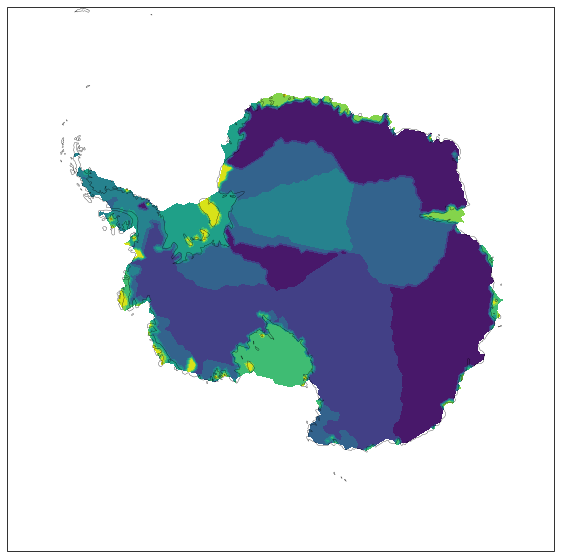

In [22]:
# TP: plot the mask
plt.figure(figsize=(10,10))
ax = plt.subplot(projection=projection)
ax.set_extent([-180,180,-90,-60], crs.PlateCarree())
fill_rotated = ax.contourf(mask.lon.values, mask.lat.values, mask['Area'].data, transform=rotated_pole)
ax.coastlines(linewidth=0.3)